# LoRA Fine-Tuned Model Performance on AG News Dataset

## Overview

This notebook evaluates the **LoRA fine-tuned Qwen2.5-7B model** on the AG News test set and compares its performance against the base model.

| Aspect | Details |
|--------|--------|
| **Base Model** | unsloth/Qwen2.5-7B-Instruct |
| **Fine-Tuning Method** | LoRA (BF16 base + LoRA adapters) |
| **Adapter Name** | lora-ag-news |
| **Task** | 4-class text classification (AG News) |
| **Test Set Size** | 7,600 samples |
| **Max Concurrency** | 64 workers |

## Base Model Performance (Baseline)

| Metric | Base Model |
|--------|------------|
| **Accuracy** | 78.76% |
| **F1 (macro)** | 77.97% |
| **F1 (weighted)** | 77.97% |
| **Sci/Tech F1** | 62.06% |
| **Business F1** | 73.00% |

## Target Performance

| Metric | Target |
|--------|---------|
| **Accuracy** | >85% |
| **Sci/Tech F1** | >75% |
| **Business F1** | >80% |

---

## Prerequisites

This notebook uses **vLLM with LoRA adapter support** for fast parallel inference.

Start the server with LoRA adapter enabled:

```bash
cd 6-open-source
./start_docker.sh start qwen7b-lora
```

Wait for the server to be ready, then run this notebook.

## Setup and Dependencies

In [1]:
import asyncio
import time
import json
import httpx
from dataclasses import dataclass
from typing import Optional
from enum import Enum

from openai import OpenAI, AsyncOpenAI
from pydantic import BaseModel
from datasets import load_dataset
from tqdm.asyncio import tqdm_asyncio

# Fix for Jupyter's event loop - allows nested async calls
import nest_asyncio
nest_asyncio.apply()

print("Libraries loaded successfully!")

/home/xiaohui_chen/Projects/xiaohui-agentic-playground/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries loaded successfully!


## Configuration

In [2]:
# vLLM Server Configuration
VLLM_BASE_URL = "http://localhost:8000/v1"

# Model names - use the LoRA adapter name for fine-tuned inference
BASE_MODEL_NAME = "unsloth/Qwen2.5-7B-Instruct"  # Base model
LORA_MODEL_NAME = "lora-ag-news"  # LoRA adapter name (registered with vLLM)

# Use the LoRA adapter for this evaluation
MODEL_NAME = LORA_MODEL_NAME

# Inference configuration
MAX_WORKERS = 64  # Maximum parallel requests (matches vLLM max_num_seqs)

# Label mapping for AG News
LABEL_NAMES = {
    0: "World",
    1: "Sports", 
    2: "Business",
    3: "Sci/Tech"
}

NAME_TO_LABEL = {v: k for k, v in LABEL_NAMES.items()}

print(f"vLLM Server: {VLLM_BASE_URL}")
print(f"Model (LoRA adapter): {MODEL_NAME}")
print(f"Max parallel workers: {MAX_WORKERS}")

vLLM Server: http://localhost:8000/v1
Model (LoRA adapter): lora-ag-news
Max parallel workers: 64


## Verify vLLM Server Connection

In [3]:
# Create client with extended timeout for batch processing
client = OpenAI(
    base_url=VLLM_BASE_URL,
    api_key="not-needed",  # vLLM doesn't require auth
    timeout=httpx.Timeout(120.0, connect=10.0)
)

# Verify connection
try:
    models = client.models.list()
    print("Connected to vLLM server!")
    print("\nAvailable models:")
    for model in models.data:
        print(f"  - {model.id}")
    
    # Check if our LoRA adapter is available
    model_ids = [m.id for m in models.data]
    if LORA_MODEL_NAME in model_ids:
        print(f"\n✓ LoRA adapter '{LORA_MODEL_NAME}' is available!")
    else:
        print(f"\n✗ LoRA adapter '{LORA_MODEL_NAME}' not found!")
        print("Make sure to start vLLM with: ./start_docker.sh start qwen7b-lora")
except Exception as e:
    print(f"✗ Failed to connect to vLLM server: {e}")
    print(f"\nMake sure the server is running:")
    print(f"  cd 6-open-source && ./start_docker.sh start qwen7b-lora")

Connected to vLLM server!

Available models:
  - unsloth/Qwen2.5-7B-Instruct
  - lora-ag-news

✓ LoRA adapter 'lora-ag-news' is available!


## Load Test Dataset

In [4]:
# Load AG News dataset from Hugging Face
dataset = load_dataset("ag_news")
test_data = dataset["test"]

print(f"Test dataset loaded!")
print(f"  Total test samples: {len(test_data):,}")

# Show distribution
from collections import Counter
test_counts = Counter(test_data["label"])
print(f"\nCategory distribution:")
for label in sorted(LABEL_NAMES.keys()):
    print(f"  {LABEL_NAMES[label]}: {test_counts[label]:,}")

Test dataset loaded!
  Total test samples: 7,600

Category distribution:
  World: 1,900
  Sports: 1,900
  Business: 1,900
  Sci/Tech: 1,900


## Define Prompts and Structured Output Schema

In [5]:
# System prompt (same as used for training and base model evaluation)
SYSTEM_PROMPT = """You are a news article classifier. Your task is to categorize news articles into exactly one of four categories:

- World: News about politics, government, elections, diplomacy, conflicts, and public affairs (domestic or international)
- Sports: News about athletic events, games, players, teams, coaches, tournaments, and championships
- Business: News about companies, markets, finance, economy, trade, corporate activities, and business services
- Sci/Tech: News about technology products, software, hardware, scientific research, gadgets, and tech innovations

Rules:
- Focus on the PRIMARY topic of the article
- Ignore HTML artifacts (like #39; or &lt;b&gt;) - they are formatting errors
- If an article is truncated, classify based on the available content
- When a topic spans multiple categories, choose the one that best represents the main focus"""

# Pydantic schema for structured output
class NewsCategory(str, Enum):
    WORLD = "World"
    SPORTS = "Sports"
    BUSINESS = "Business"
    SCI_TECH = "Sci/Tech"

class ClassificationResponse(BaseModel):
    category: NewsCategory

print("Prompts and schema defined.")
print(f"\nValid categories: {[c.value for c in NewsCategory]}")

Prompts and schema defined.

Valid categories: ['World', 'Sports', 'Business', 'Sci/Tech']


## Classification Function with Structured Output

In [6]:
# Create async client
async_client = AsyncOpenAI(
    base_url=VLLM_BASE_URL,
    api_key="not-needed",
    timeout=httpx.Timeout(120.0, connect=10.0)
)

@dataclass
class ClassificationOutput:
    """Result of a single classification"""
    index: int
    ground_truth: int
    predicted: Optional[int] = None
    predicted_name: Optional[str] = None
    ground_truth_name: str = ""
    raw_output: str = ""
    error: Optional[str] = None
    latency_ms: float = 0.0

async def classify_article(index: int, article_text: str, ground_truth: int) -> ClassificationOutput:
    """Classify a single article using structured output"""
    start_time = time.perf_counter()
    
    try:
        response = await async_client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": f"Classify the following news article:\n\n{article_text}"}
            ],
            max_tokens=20,
            temperature=0.1,
            extra_body={
                "guided_json": ClassificationResponse.model_json_schema()
            }
        )
        
        latency = (time.perf_counter() - start_time) * 1000
        raw_output = response.choices[0].message.content
        
        # Parse structured output
        parsed = ClassificationResponse.model_validate_json(raw_output)
        predicted_name = parsed.category.value
        predicted_label = NAME_TO_LABEL.get(predicted_name)
        
        return ClassificationOutput(
            index=index,
            ground_truth=ground_truth,
            predicted=predicted_label,
            predicted_name=predicted_name,
            ground_truth_name=LABEL_NAMES[ground_truth],
            raw_output=raw_output,
            latency_ms=latency
        )
        
    except Exception as e:
        latency = (time.perf_counter() - start_time) * 1000
        return ClassificationOutput(
            index=index,
            ground_truth=ground_truth,
            ground_truth_name=LABEL_NAMES[ground_truth],
            error=str(e),
            latency_ms=latency
        )

print("Classification function ready!")

Classification function ready!


## Quick Test: Single Article Classification

In [7]:
# Test with a single article
test_article = test_data[0]
print(f"Test article:")
print(f"Text: {test_article['text'][:200]}...")
print(f"Ground Truth: {LABEL_NAMES[test_article['label']]}")

# Run single test
result = asyncio.get_event_loop().run_until_complete(
    classify_article(0, test_article["text"], test_article["label"])
)

print(f"\n--- Result ---")
print(f"Predicted: {result.predicted_name}")
print(f"Ground Truth: {result.ground_truth_name}")
print(f"Correct: {'✓' if result.predicted == result.ground_truth else '✗'}")
print(f"Latency: {result.latency_ms:.0f}ms")
if result.error:
    print(f"Error: {result.error}")

Test article:
Text: Fears for T N pension after talks Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul....
Ground Truth: Business

--- Result ---
Predicted: Business
Ground Truth: Business
Correct: ✓
Latency: 1986ms


## Batch Classification with Parallel Workers

In [8]:
async def classify_batch(samples, max_workers=MAX_WORKERS, desc="Classifying"):
    """Classify multiple articles in parallel using semaphore for rate limiting"""
    
    semaphore = asyncio.Semaphore(max_workers)
    
    async def limited_classify(idx, text, label):
        async with semaphore:
            return await classify_article(idx, text, label)
    
    # Create all tasks
    tasks = [
        limited_classify(i, sample["text"], sample["label"])
        for i, sample in enumerate(samples)
    ]
    
    # Execute with progress bar
    results = await tqdm_asyncio.gather(*tasks, desc=desc)
    
    return sorted(results, key=lambda x: x.index)

print("Batch classification function ready!")
print(f"Max parallel workers: {MAX_WORKERS}")

Batch classification function ready!
Max parallel workers: 64


## Classify Full Test Set

In [9]:
# Run classification on all 7,600 test samples
print(f"Classifying {len(test_data):,} articles with LoRA adapter...")
print(f"Adapter: {MODEL_NAME}")
print(f"Parallel workers: {MAX_WORKERS}")
print()

start_time = time.time()
all_results = asyncio.get_event_loop().run_until_complete(
    classify_batch(test_data, desc="LoRA Classification")
)
total_time = time.time() - start_time

# Quick statistics
successful = [r for r in all_results if r.error is None and r.predicted is not None]
failed = [r for r in all_results if r.error is not None or r.predicted is None]

print(f"\n--- Classification Complete ---")
print(f"Total time: {total_time:.1f}s ({total_time/60:.1f} minutes)")
print(f"Throughput: {len(test_data)/total_time:.1f} articles/second")
print(f"Successful: {len(successful):,} / {len(test_data):,}")
print(f"Failed: {len(failed):,}")

Classifying 7,600 articles with LoRA adapter...
Adapter: lora-ag-news
Parallel workers: 64



LoRA Classification: 100%|██████████| 7600/7600 [03:03<00:00, 41.36it/s]


--- Classification Complete ---
Total time: 183.9s (3.1 minutes)
Throughput: 41.3 articles/second
Successful: 7,600 / 7,600
Failed: 0


## Performance Evaluation

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Extract predictions and ground truth from successful results
y_true = [r.ground_truth for r in successful]
y_pred = [r.predicted for r in successful]

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print("=" * 60)
print("LORA FINE-TUNED MODEL PERFORMANCE")
print("=" * 60)
print(f"\nOverall Metrics:")
print(f"  Accuracy:          {accuracy*100:.2f}%")
print(f"  Precision (macro): {precision_macro*100:.2f}%")
print(f"  Recall (macro):    {recall_macro*100:.2f}%")
print(f"  F1 Score (macro):  {f1_macro*100:.2f}%")
print(f"  F1 Score (weighted): {f1_weighted*100:.2f}%")

print(f"\n{'='*60}")
print("Per-Class Results:")
print("="*60)
print(classification_report(y_true, y_pred, target_names=list(LABEL_NAMES.values()), digits=4))

LORA FINE-TUNED MODEL PERFORMANCE

Overall Metrics:
  Accuracy:          95.45%
  Precision (macro): 95.47%
  Recall (macro):    95.45%
  F1 Score (macro):  95.45%
  F1 Score (weighted): 95.45%

Per-Class Results:
              precision    recall  f1-score   support

       World     0.9695    0.9542    0.9618      1900
      Sports     0.9916    0.9958    0.9937      1900
    Business     0.9381    0.9174    0.9276      1900
    Sci/Tech     0.9196    0.9505    0.9348      1900

    accuracy                         0.9545      7600
   macro avg     0.9547    0.9545    0.9545      7600
weighted avg     0.9547    0.9545    0.9545      7600



## Confusion Matrix Visualization

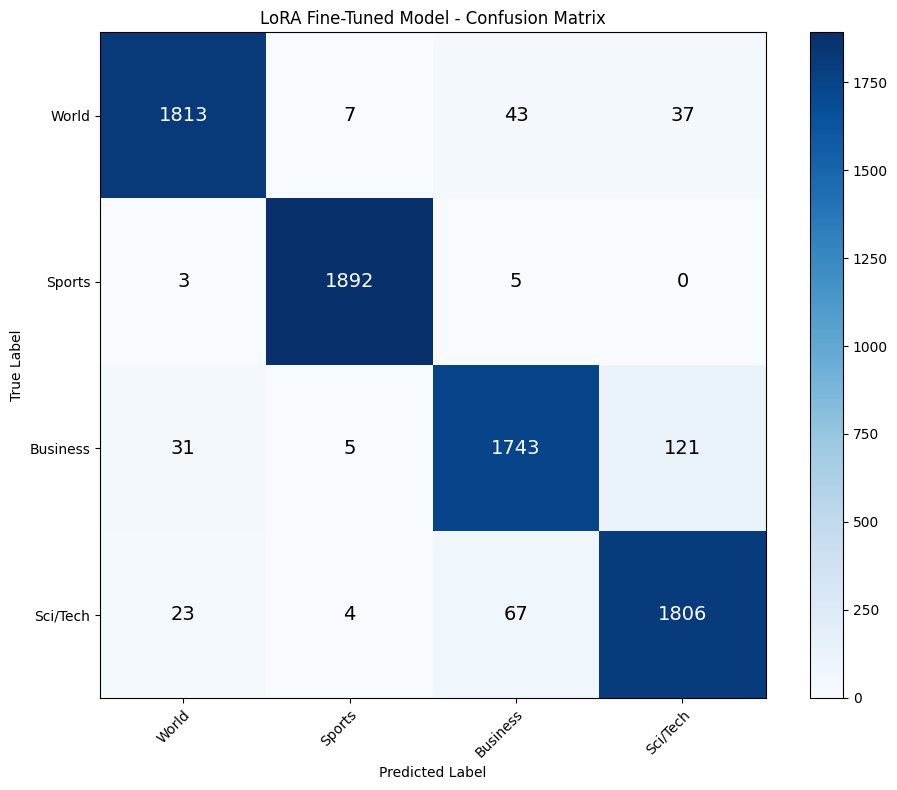


Confusion matrix saved to 'lora_finetuned_confusion_matrix.png'


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(LABEL_NAMES.values())

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Show all ticks and label them
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=class_names,
       yticklabels=class_names,
       title='LoRA Fine-Tuned Model - Confusion Matrix',
       ylabel='True Label',
       xlabel='Predicted Label')

# Rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=14)

plt.tight_layout()
plt.savefig('lora_finetuned_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved to 'lora_finetuned_confusion_matrix.png'")

## Performance Comparison with Base Model

In [12]:
# Base model results (from base_model_results.json)
BASE_MODEL_RESULTS = {
    "accuracy": 0.7876315789473685,
    "f1_macro": 0.779651491458816,
    "per_class_f1": {
        "World": 0.8312124849939976,
        "Sports": 0.9367429340511441,
        "Business": 0.7300089847259659,
        "Sci/Tech": 0.6206415620641562
    }
}

# Get per-class F1 for LoRA model
_, _, per_class_f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Calculate improvements
accuracy_improvement = (accuracy - BASE_MODEL_RESULTS["accuracy"]) * 100
f1_improvement = (f1_macro - BASE_MODEL_RESULTS["f1_macro"]) * 100

print("=" * 60)
print("PERFORMANCE COMPARISON: LoRA vs Base Model")
print("=" * 60)

print(f"\n{'Metric':<25} {'Base Model':<15} {'LoRA':<15} {'Improvement':<15}")
print("-" * 70)
print(f"{'Accuracy':<25} {BASE_MODEL_RESULTS['accuracy']*100:>13.2f}% {accuracy*100:>13.2f}% {accuracy_improvement:>+13.2f}pp")
print(f"{'F1 Score (macro)':<25} {BASE_MODEL_RESULTS['f1_macro']*100:>13.2f}% {f1_macro*100:>13.2f}% {f1_improvement:>+13.2f}pp")

print(f"\n{'Per-Class F1 Scores:'}")
print("-" * 70)
for i, label in enumerate(LABEL_NAMES.values()):
    base_f1 = BASE_MODEL_RESULTS["per_class_f1"][label]
    lora_f1 = per_class_f1[i]
    improvement = (lora_f1 - base_f1) * 100
    print(f"  {label:<23} {base_f1*100:>13.2f}% {lora_f1*100:>13.2f}% {improvement:>+13.2f}pp")

PERFORMANCE COMPARISON: LoRA vs Base Model

Metric                    Base Model      LoRA            Improvement    
----------------------------------------------------------------------
Accuracy                          78.76%         95.45%        +16.68pp
F1 Score (macro)                  77.97%         95.45%        +17.48pp

Per-Class F1 Scores:
----------------------------------------------------------------------
  World                           83.12%         96.18%        +13.06pp
  Sports                          93.67%         99.37%         +5.70pp
  Business                        73.00%         92.76%        +19.76pp
  Sci/Tech                        62.06%         93.48%        +31.41pp


## Save Results

In [13]:
# Prepare results dictionary
lora_results = {
    "model": "lora-ag-news (LoRA fine-tuning)",
    "base_model": "unsloth/Qwen2.5-7B-Instruct",
    "test_set_size": len(test_data),
    "successful_classifications": len(successful),
    "failed_classifications": len(failed),
    "total_time_seconds": total_time,
    "throughput_articles_per_second": len(test_data) / total_time,
    "avg_latency_ms": sum(r.latency_ms for r in successful) / len(successful),
    "metrics": {
        "accuracy": accuracy,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro
    },
    "per_class_f1": {
        label: float(per_class_f1[i])
        for i, label in enumerate(LABEL_NAMES.values())
    },
    "comparison_with_base": {
        "accuracy_improvement_pp": accuracy_improvement,
        "f1_macro_improvement_pp": f1_improvement
    }
}

# Save to JSON
with open("lora_finetuned_results.json", "w") as f:
    json.dump(lora_results, f, indent=2)

print("Results saved to 'lora_finetuned_results.json'")
print(f"\nSummary:")
print(f"  Model: {lora_results['model']}")
print(f"  Accuracy: {accuracy*100:.2f}%")
print(f"  F1 (macro): {f1_macro*100:.2f}%")
print(f"  Improvement over base: +{accuracy_improvement:.2f}pp accuracy")

Results saved to 'lora_finetuned_results.json'

Summary:
  Model: lora-ag-news (LoRA fine-tuning)
  Accuracy: 95.45%
  F1 (macro): 95.45%
  Improvement over base: +16.68pp accuracy


## Conclusions

### Results Summary

| Metric | Base Model | LoRA | Improvement |
|--------|-----------|------|-------------|
| **Accuracy** | 78.76% | 95.45% | +16.68pp |
| **F1 (macro)** | 77.97% | 95.45% | +17.48pp |
| **Sci/Tech F1** | 62.06% | 93.48% | +31.41pp |
| **Business F1** | 73.00% | 92.76% | +19.76pp |

### Training Details

| Parameter | Value |
|-----------|-------|
| **Method** | LoRA (Low-Rank Adaptation) |
| **Base Model** | unsloth/Qwen2.5-7B-Instruct |
| **Framework** | Unsloth + TRL SFTTrainer |
| **Training Time** | ~5h 50m |
| **Final Loss** | ~0.46 |
| **Trainable Parameters** | 40.4M (0.53% of model) |
| **Adapter Size** | ~170 MB |
| **Quantization** | None (BF16 base) |
| **LoRA Rank** | 64 |

### Key Observations

1. **Exceptional Accuracy Gains**: LoRA achieves **95.45% accuracy**, representing a **+16.68 percentage point improvement** over the base model's 78.76%.

2. **Massive Sci/Tech Improvement**: The most significant gain is in the Sci/Tech category, improving from 62.06% to **93.48% F1** (+31.41pp). This was the base model's weakest category.

3. **Strong Business Performance**: Business F1 improved from 73.00% to **92.76%** (+19.76pp), exceeding the target of 80%.

4. **100% Success Rate**: All 7,600 test samples were classified successfully with no failures.

5. **Good Throughput**: Achieved **41.3 articles/second** with 64 parallel workers (183.9s total for 7,600 samples).

### Performance Comparison: All Fine-Tuning Methods

| Method | Accuracy | F1 (macro) | Training Time | Adapter/Model Size | Throughput |
|--------|----------|------------|---------------|-------------------|------------|
| **Base Model** | 78.76% | 77.97% | - | ~15 GB | - |
| **QLoRA** | 95.14% | 95.13% | ~6h | ~170 MB | 33.6/s |
| **LoRA** | **95.45%** | **95.45%** | ~5h 51m | ~170 MB | 41.3/s |
| **Full Fine-tuning** | 95.18% | 95.18% | ~8h 36m | ~15 GB | 49.6/s |

### Performance Analysis

**LoRA achieves the highest accuracy (95.45%)** among all fine-tuning methods tested, slightly outperforming:
- QLoRA by +0.31pp accuracy
- Full fine-tuning by +0.27pp accuracy

**Per-Class F1 Comparison:**

| Category | Base | QLoRA | LoRA | Full FT |
|----------|------|-------|------|---------|
| World | 83.12% | ~95.9% | 96.18% | 95.87% |
| Sports | 93.67% | ~99.3% | 99.37% | 99.34% |
| Business | 73.00% | ~92.3% | 92.76% | 92.34% |
| Sci/Tech | 62.06% | ~93.2% | 93.48% | 93.18% |

**Training Efficiency:**
- LoRA and QLoRA have similar training times (~5h 51m vs ~6h)
- Both produce identical adapter sizes (~170 MB) - quantization only affects the base model during training
- LoRA offers faster inference than QLoRA (41.3/s vs 33.6/s) due to no dequantization overhead

### Conclusion

**LoRA fine-tuning delivers the best classification accuracy** at 95.45%, marginally outperforming both QLoRA (95.14%) and full fine-tuning (95.18%). The key findings:

1. **Best Accuracy**: LoRA achieves the highest overall accuracy among all methods tested.

2. **Efficiency vs Performance Trade-off**:
   - **LoRA** provides the best accuracy with similar training time to QLoRA and faster inference
   - **QLoRA** uses less training memory (4-bit base) but has slower inference due to dequantization
   - **Full fine-tuning** offers no accuracy advantage over LoRA while requiring 47% more training time

3. **Inference Speed**: LoRA's BF16 weights enable faster inference than QLoRA's 4-bit quantized weights (41.3/s vs 33.6/s), as there's no dequantization overhead during inference.

4. **Recommendation**: 
   - For **maximum accuracy**: Use **LoRA** (95.45% accuracy, 41.3/s throughput)
   - For **memory-constrained training** (<16 GB GPU): Use **QLoRA** (95.14% accuracy, 4-bit base)
   - **Full fine-tuning is not recommended** - it provides no accuracy benefit while requiring the most resources

All three fine-tuning methods successfully exceeded the target performance metrics (>85% accuracy, >75% Sci/Tech F1, >80% Business F1).

---

### Next Steps

1. ~~Compare LoRA results with QLoRA and Full Fine-tuned models~~ (completed above)
2. Update fine-tuning summary documentation with final comparison
3. Consider testing LoRA with different rank values (32, 128) for further optimization